# Salary Predictions Based on Job Descriptions
***

# Table of Content

## Part 1 - Define
[1 Define the problem](#1)

## Part 2 - Discover
[2 Load the data and Examine the data](#2)

[3 Clean the data](#3)
- Drop rows where salary is equals to zero

[4 Explore the data](#4)
- Salary is correlated most with job type (>0.5 in correlation)
- Salary is weakly correlated with major, degree, and years of experience (between 0.3-0.4 in correlation)
- Industry, companyID, and distance from metropolis are very weakly correlated with salary (<0.3 in correlation)
- Using a square-root-transform of salary maintains the information but can potentially improves model performance

[5 Establish a baseline](#5)

[6 Hypothesize a solution](#6)

## Part 3 - Develop
[7 Engineering features](#7)

[8 Create modesl](#8)

[9 Test models](#9)

[10 Select best model](#10)

## Part 4 - Deploy
[11 Automate pipeline](#11)

[12 Deploy solution](#12)

[13 Measure efficacy](#13)

# Part 1 - DEFINE

<a id = '1'></a>
### ---- 1 Define the problem ----

This is a salary prediction problem.

The training set contains jobs where both job descriptions and salaries are available. The test set contains jobs where only job descriptions are available.

The objective is to learn from the information provided in the job description to predict the salary.

In [1]:
#import libraries

#computing libs
import pandas as pd
import numpy as np
import scipy as sp

#viz libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ml libs
import sklearn as sk
from sklearn.metrics import confusion_matrix

#other libs
import warnings
warnings.filterwarnings('ignore')

#info
__author__ = "Hieu Nguyen"
__email__ = "hieu.t.nguyen.aug25@gmail.com"

## Part 2 - DISCOVER

<a id = '2'></a>
### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
train_features = pd.read_csv("data/train_features.csv")
train_target = pd.read_csv("data/train_salaries.csv")
test_features = pd.read_csv("data/test_features.csv")

#### Examine the data

In [3]:
train_features.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [4]:
train_target.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [5]:
test_features.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


#### Further examination with .info()

In [6]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


<a id = '3'></a>
### ---- 3 Clean the data ----

In [9]:
#count the number of duplicated rows
print('test_features',test_features.duplicated().sum())
print('train_target',train_target.duplicated().sum())
print('train_features',train_features.duplicated().sum())

test_features 0
train_target 0
train_features 0


In [10]:
#if jobId is unique, there will zero duplicates
print('jobId in test_features',test_features['jobId'].duplicated().sum())
print('jobId in train_target',train_target['jobId'].duplicated().sum())
print('jobId in train_features',train_features['jobId'].duplicated().sum())

jobId in test_features 0
jobId in train_target 0
jobId in train_features 0


In [48]:
#if the jobId for the training sets are matching, there should be 1,000,000 rows
train_features['jobId'].eq(train_target['jobId']).sum() == 1000000

True

In [14]:
#merge the train_target and train_features df by jobId
train = train_features.merge(train_target, on = 'jobId')

In [15]:
train.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [16]:
#merging successful
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [27]:
#look for salaries <= 0 in the train df
train[train['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [18]:
#look for NA in any of the features in the train df
train.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [28]:
#look for NA in any of the features in the test df
test_features.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [30]:
#decision: drop the rows were salary is equals to zero.
train = train[train.salary > 0]

In [56]:
cat_features = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']

<a id = '4'></a>
### ---- 4 Explore the data (EDA) ----

In [39]:
#create visualize_features function
def visualize_features(df,col):
    plt.figure(figsize = (18,8))
    if df[col].dtype == 'int64':
        #if column is numeric, plot a boxplot and the relationship between this feature and salary
        plt.subplot(121)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, alpha = 0.1)
        plt.subplot(122)
        sns.boxplot(train[col])
    else:
        #if column is categorical, plot a boxplot of salary grouped by the category's values
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        sns.boxplot(x = col, y = 'salary', data = df)
    plt.ylabel('Salaries')
    plt.show()

#### Visualize the features

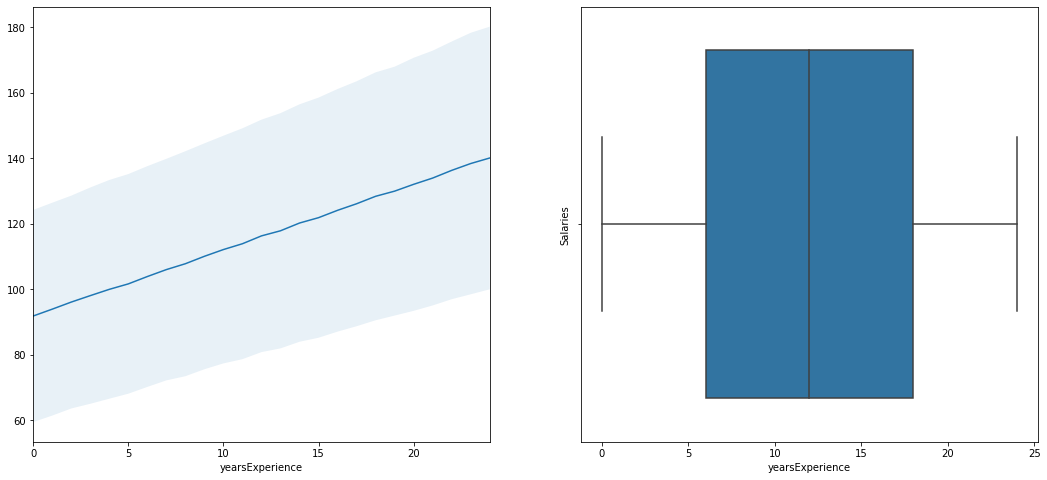

In [40]:
visualize_features(train,'yearsExperience')

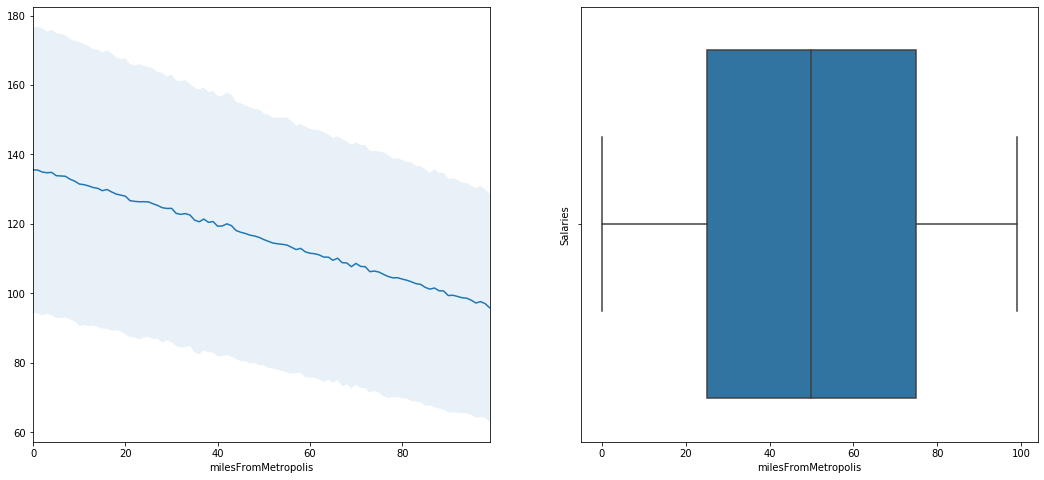

In [41]:
visualize_features(train, 'milesFromMetropolis')

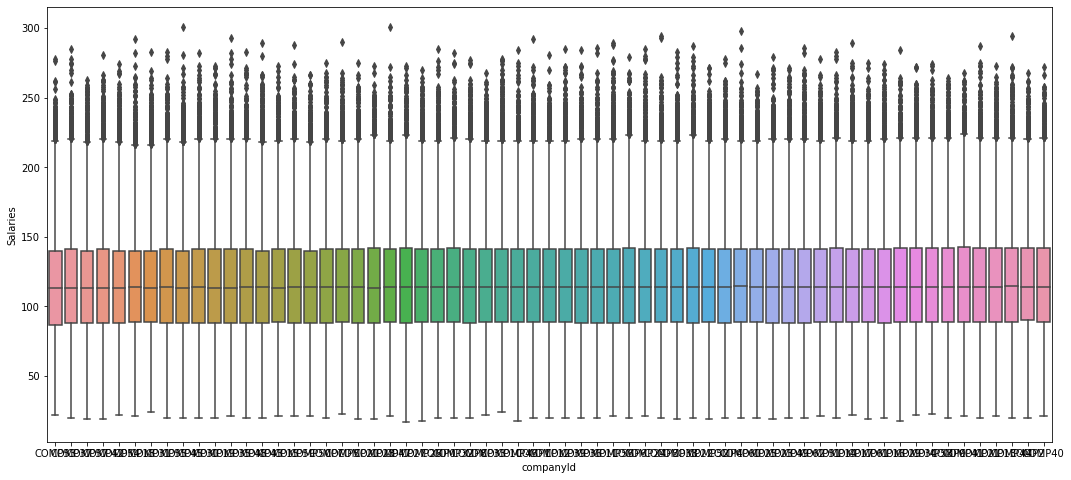

In [54]:
visualize_features(train, 'companyId')

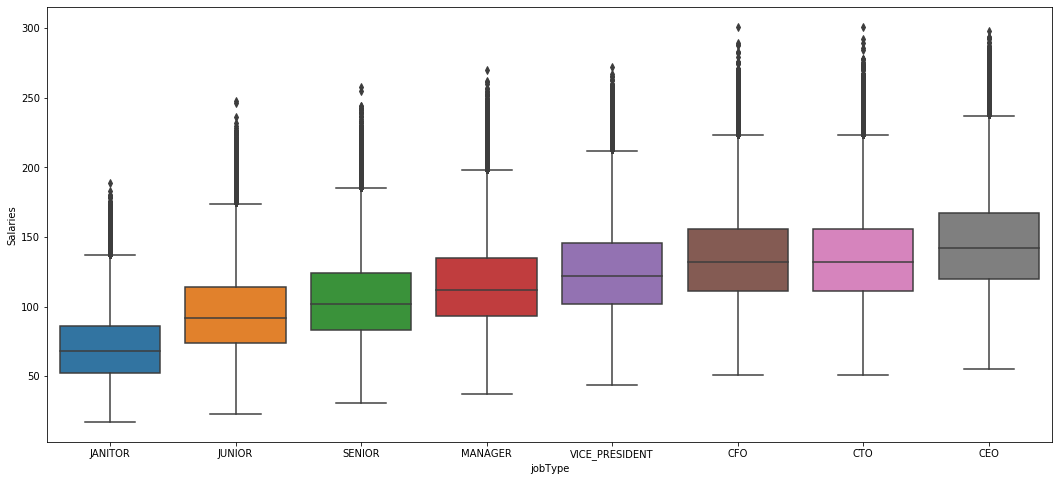

In [43]:
visualize_features(train, 'jobType')

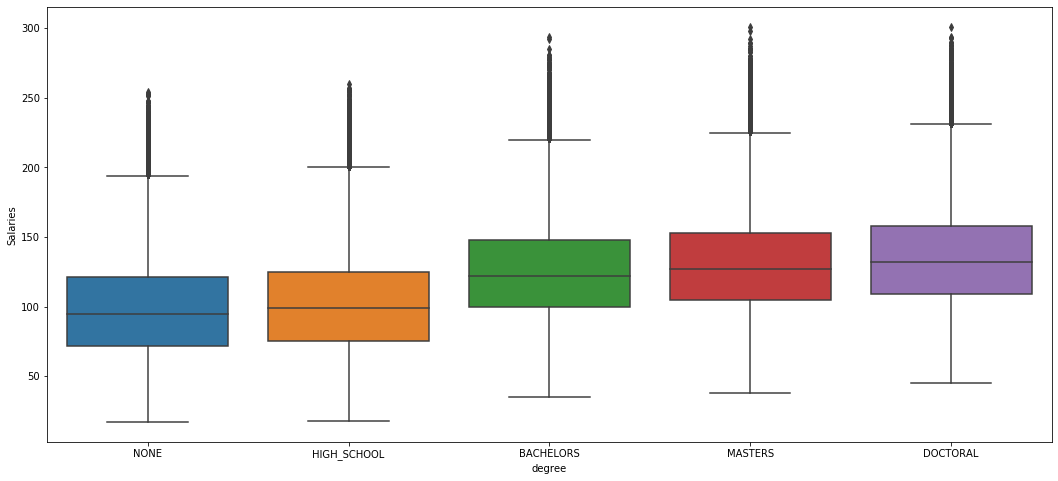

In [44]:
visualize_features(train, 'degree')

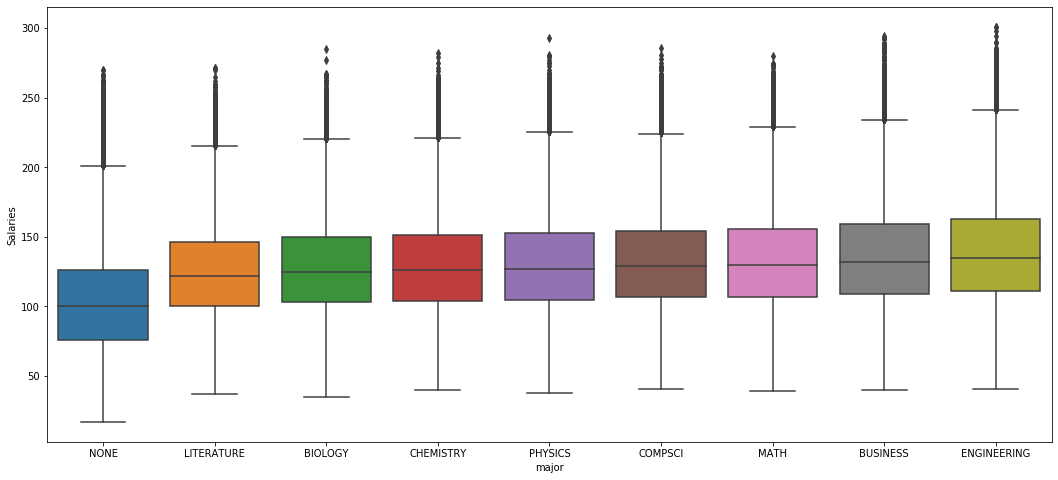

In [45]:
visualize_features(train, 'major')

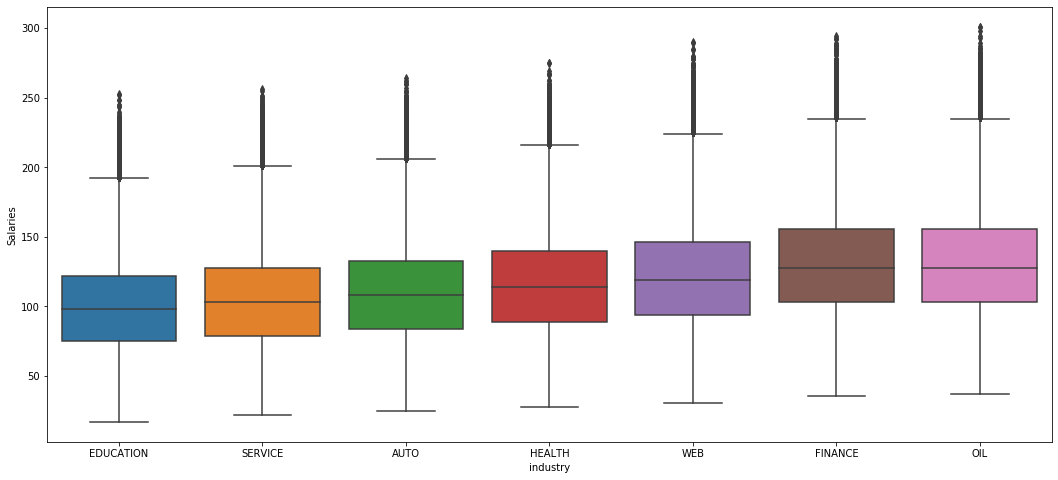

In [46]:
visualize_features(train, 'industry')

#### Visualize the target variable

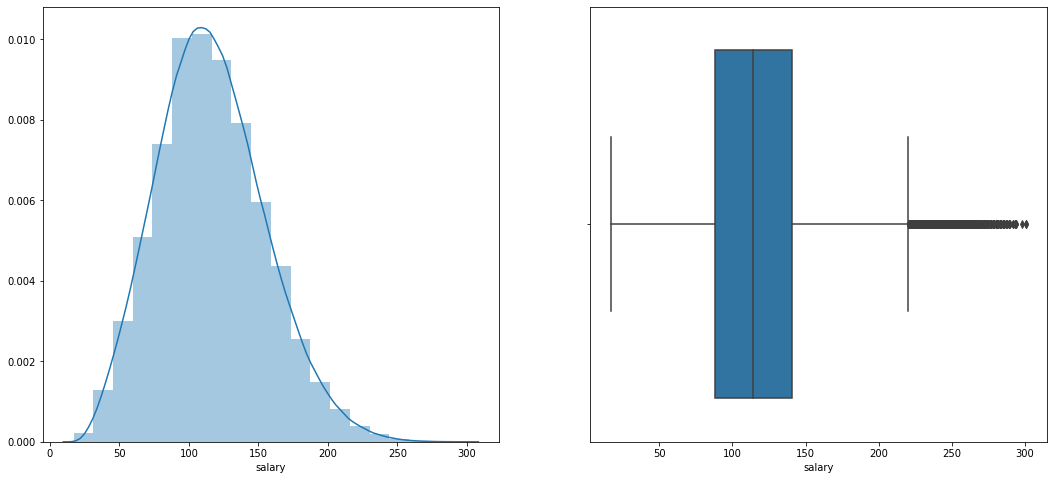

In [47]:
plt.figure(figsize = (18,8))
plt.subplot(121)
sns.distplot(train.salary, bins = 20)
plt.subplot(122)
sns.boxplot(train.salary)
plt.show()

In [70]:
train['salary'].describe()

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

#### The raw salary is positively skewed

In [57]:
sp.stats.skew(train.salary)

0.3465267592829531

**Statistics Note:** When a variable to predict is skewed, transforming the variable toward normality will improve the performance of models such as Linear Regression and Logistic Regression. 

In [51]:
#transforming the raw salary variable by log
train['logSalary'] = np.log(train.salary)

#### Visualize the log-transformed target variable

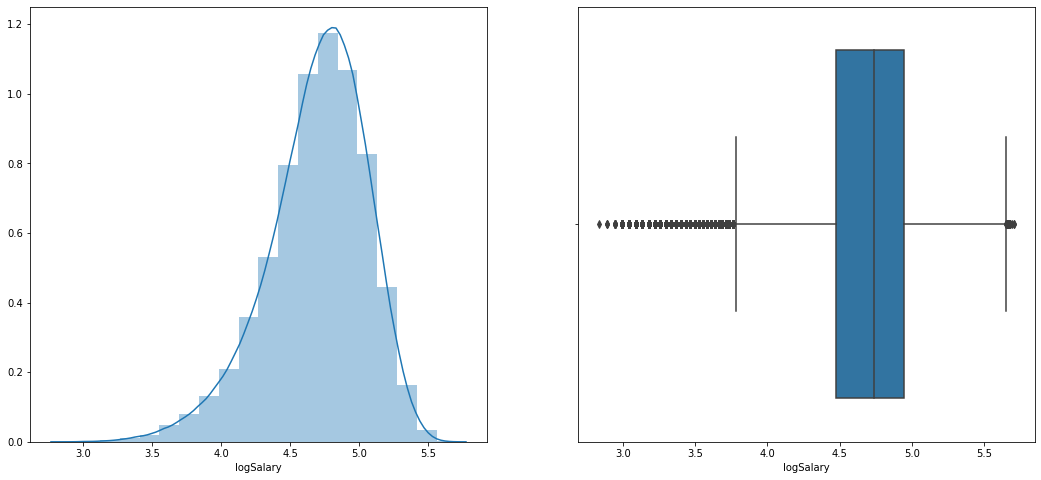

In [52]:
plt.figure(figsize = (18,8))
plt.subplot(121)
sns.distplot(train.logSalary, bins = 20)
plt.subplot(122)
sns.boxplot(train.logSalary)
plt.show()

#### The log-transformed salary is now even more skewed than the raw salary in the negative direction

In [53]:
sp.stats.skew(train.logSalary)

-0.6647733123031915

**Statistics Note:** When a variable is still not normal after being log-transformed, it is best to use another transformation methods, such as square-root.

In [58]:
#tranforming the raw salary variable by square-root
train['sqrtSalary'] = np.sqrt(train.salary)

#### Visualize the square-root-transformed target variable

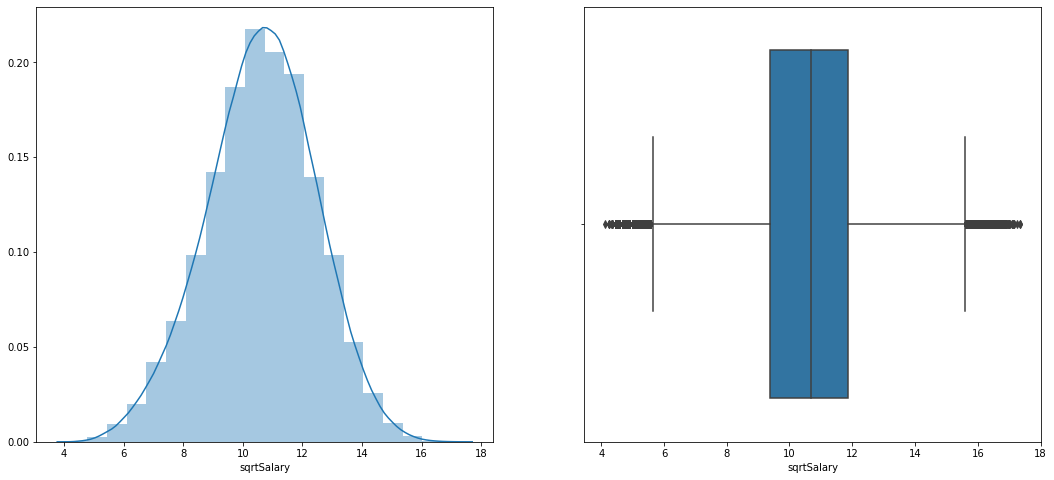

In [59]:
plt.figure(figsize = (18,8))
plt.subplot(121)
sns.distplot(train.sqrtSalary, bins = 20)
plt.subplot(122)
sns.boxplot(train.sqrtSalary)
plt.show()

#### The square-root-transformed salary is now much closer to a normal distribution

In [60]:
sp.stats.skew(train.sqrtSalary)

-0.1280479484037874

In [62]:
train['sqrtSalary'].describe()

count    999995.000000
mean         10.616488
std           1.831004
min           4.123106
25%           9.380832
50%          10.677078
75%          11.874342
max          17.349352
Name: sqrtSalary, dtype: float64

#### Visualize correlation between features and target variables

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 11 columns):
jobId                  999995 non-null object
companyId              999995 non-null category
jobType                999995 non-null category
degree                 999995 non-null category
major                  999995 non-null category
industry               999995 non-null category
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
logSalary              999995 non-null float64
sqrtSalary             999995 non-null float64
dtypes: category(5), float64(2), int64(3), object(1)
memory usage: 98.2+ MB


In [64]:
# Encode categorical variables with their group mean
def encode_label(df, col):
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)

for col in train.columns:
    if train[col].dtype.name == "category":
        encode_label(train, col)

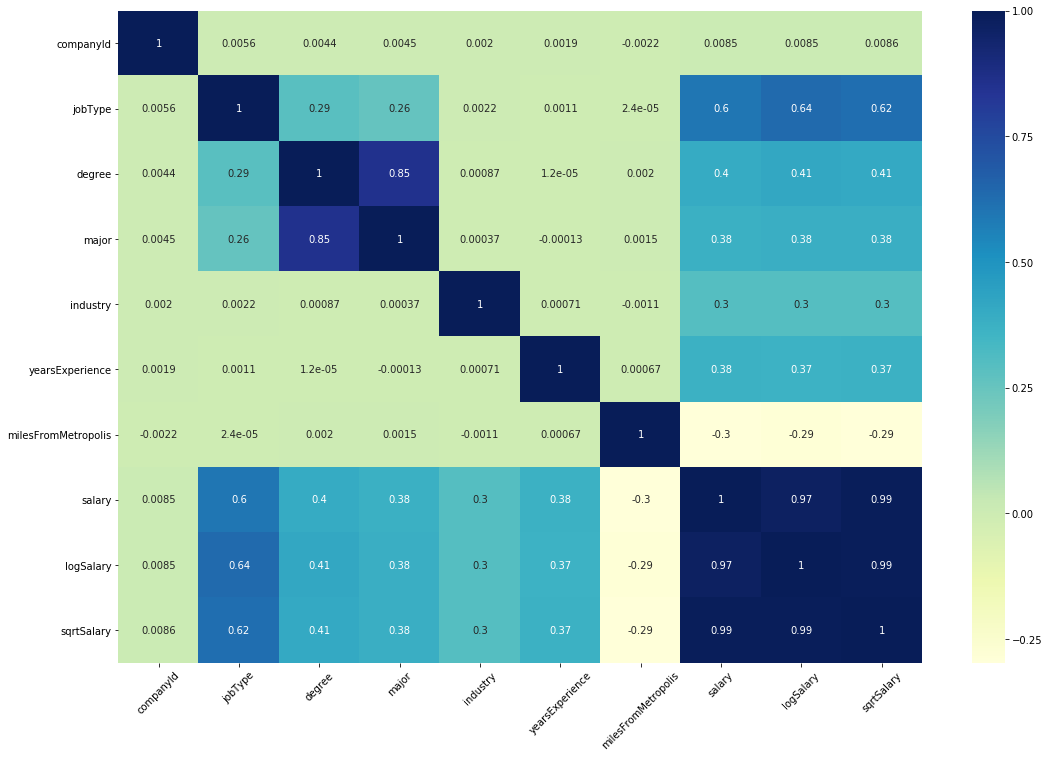

In [69]:
fig = plt.figure(figsize=(18, 12))
sns.heatmap(train[cat_features + num_features + ['salary', 'logSalary', 'sqrtSalary']].corr(), cmap='YlGnBu', annot=True)
plt.xticks(rotation=45)
plt.show()

**Statistic Note:**
The square-root-transformation of the target variable is now a very good candidate for ML models since this tranformation:
- keeps the correlation structure between the target variable and the features
- improves the performance of Linear Regression and Logistic Regression models by tranforming the target variable toward a normal distribution

<a id = '5'></a>
### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

<a id = '6'></a>
### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

<a id = '7'></a>
### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

<a id = '8'></a>
### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

<a id = '9'></a>
### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

<a id = '10'></a>
### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

<a id = '11'></a>
### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

<a id = '12'></a>
### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

<a id = '13'></a>
### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data